Articles :
   1. [Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)
   2. [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
   3. [How to Develop an Encoder-Decoder Model with Attention for Sequence-to-Sequence Prediction in Keras](https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/)
   4. [Attention in Long Short-Term Memory Recurrent Neural Networks]()
   5. [How Does Attention Work in Encoder-Decoder Recurrent Neural Networks](https://machinelearningmastery.com/how-does-attention-work-in-encoder-decoder-recurrent-neural-networks/)
   6. [Attention and Memory in Deep Learning and NLP](http://www.wildml.com/2016/01/attention-and-memory-in-deep-learning-and-nlp/)

# CNN (full input) + Bidirectional LSTM

## Define and train the model

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

In [133]:
n = 16    # founders
p = 1015  # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 100   # nb of itérations

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants.

In [134]:
with open("Recombinations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo = np.array(haplo[:n])
    d_haplo = np.array(haplo[n:])
display(F_haplo.shape,d_haplo.shape)
        
with open("Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])
    d_geno = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno.shape,d_geno.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [135]:
xtrain = d_geno[:3*I*N//4]
ytrain = d_haplo[:3*I*N//4]
xtest = d_geno[3*I*N//4:]
ytest = d_haplo[3*I*N//4:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((7500, 1015), (7500, 1015), (2500, 1015), (2500, 1015))

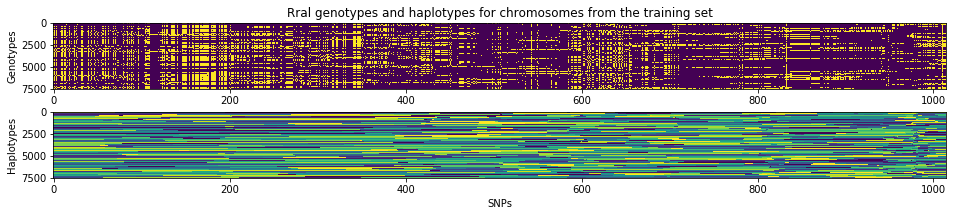

In [136]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
ax1.imshow(xtrain, aspect = 0.01)
ax1.set(ylabel = "Genotypes", title = "Rral genotypes and haplotypes for chromosomes from the training set")
ax2.imshow(ytrain, aspect = 0.01)
ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
plt.show()

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [137]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 2 SNPs-long segments.

In [138]:
def chromosome_segments_output (array):
    A = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        A[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return A

In [139]:
Xtrain = chromosome_alternate_inputs_5(xtrain, F_geno, linkage, n)
display(Xtrain.shape)
Ytrain = chromosome_segments_output(ytrain)[:,:-2]       # Delete 1 SNP to get the right dimension (CNN output)
display(Ytrain.shape)
Xtest = chromosome_alternate_inputs_5(xtest, F_geno, linkage, n)
display(Xtest.shape)
Ytest = chromosome_segments_output(ytest)[:,:-2]
display(Ytest.shape)

(7500, 1015, 49)

(7500, 505, 16)

(2500, 1015, 49)

(2500, 505, 16)

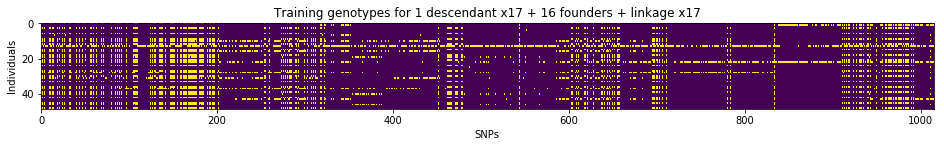

In [140]:
im, ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(Xtrain[0].T, aspect = 2)
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Training genotypes for 1 descendant x17 + 16 founders + linkage x17")
plt.show()

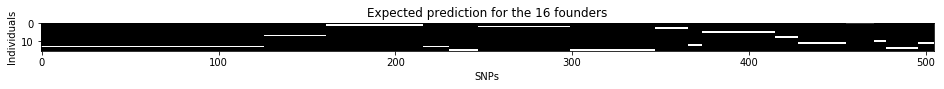

In [141]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.imshow(Ytrain[0].T, aspect = 1, cmap = "Greys_r")
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Expected prediction for the 16 founders")
plt.show()

**Define LSTM** :

In [142]:
K.clear_session()

model_5 = Sequential()
model_5.add(Conv1D(49, kernel_size=3,
                 activation='relu',
                 input_shape=Xtest.shape[1:]))
model_5.add(Conv1D(30, kernel_size=3, activation='relu'))
model_5.add(AveragePooling1D(pool_size=2,strides=2))
model_5.add(Dropout(0.25))
model_5.add(Conv1D(16, kernel_size=3, activation='relu'))
model_5.add(Dropout(0.25))
model_5.add(TimeDistributed(Dense(16, activation='relu')))
model_5.add(Dropout(0.5))
model_5.add(TimeDistributed(Dense(16, activation='relu')))
model_5.add(Dropout(0.5))
model_5.add(Bidirectional(LSTM(8, return_sequences=True)))
model_5.add(TimeDistributed(Dense(Ytest.shape[2], activation='softmax')))
model_5.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
filepath="LSTM5_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model_5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1014, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1013, 30)          2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 506, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 506, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 505, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 505, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 505, 16)           272       
__________

In [129]:
plot_model(model_5, show_shapes=True, to_file='Models/LSTM5_model.png')

**Train LSTM** :

In [131]:
epochs=1
model_5.fit(Xtrain, Ytrain,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(Xtest, Ytest))

Train on 7500 samples, validate on 2500 samples
Epoch 1/1
7500/7500 [==============================] - 668s 89ms/step - loss: 2.5020 - acc: 0.1622 - val_loss: 2.3176 - val_acc: 0.1830

Epoch 00001: val_acc improved from -inf to 0.18298, saving model to LSTM5_model_weights-improvement-01-0.18.hdf5


$\to$ Reached **43% accuracy after 99 epochs**.

## Load Check-Pointed model and make predictions : new simulations

In [160]:
with open("Recombinations_haplotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo_test = np.array(haplo[:n])
    d_haplo_test = np.array(haplo[n:])
display(F_haplo_test.shape,d_haplo_test.shape)
        
with open("Recombinations_genotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno_test = np.array(geno[:n])
    d_geno_test = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno_test.shape,d_geno_test.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [161]:
K.clear_session()

model_5 = Sequential()
model_5.add(Conv1D(49, kernel_size=3,
                 activation='relu',
                 input_shape=Xtest.shape[1:]))
model_5.add(Conv1D(30, kernel_size=3, activation='relu'))
model_5.add(AveragePooling1D(pool_size=2,strides=2))
model_5.add(Dropout(0.25))
model_5.add(Conv1D(16, kernel_size=3, activation='relu'))
model_5.add(Dropout(0.25))
model_5.add(TimeDistributed(Dense(16, activation='relu')))
model_5.add(Dropout(0.5))
model_5.add(TimeDistributed(Dense(16, activation='relu')))
model_5.add(Dropout(0.5))
model_5.add(Bidirectional(LSTM(8, return_sequences=True)))
model_5.add(TimeDistributed(Dense(Ytest.shape[2], activation='softmax')))
model_5.load_weights("Models/LSTM5_model_weights/LSTM5_model_weights-improvement-99-0.43.hdf5")       # load weights
model_5.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model_5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1014, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1013, 30)          2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 506, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 506, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 505, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 505, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 505, 16)           272       
__________

In [185]:
Xdata = chromosome_alternate_inputs_5(d_geno_test, F_geno_test, linkage, n)
display(Xdata.shape)
Ydata = chromosome_segments_output(d_haplo_test)[:,:-2]       # Delete 1 SNP to get the right dimension (CNN output)
display(Ydata.shape)
Ypred = model_5.predict(Xdata)
display(Ypred.shape)

(10000, 1015, 49)

(10000, 505, 16)

(10000, 505, 16)

In [186]:
model_5.evaluate(Xdata, Ydata)

10000/10000 [==============================] - 178s 18ms/step


[1.7003124328613282, 0.4092665348529816]

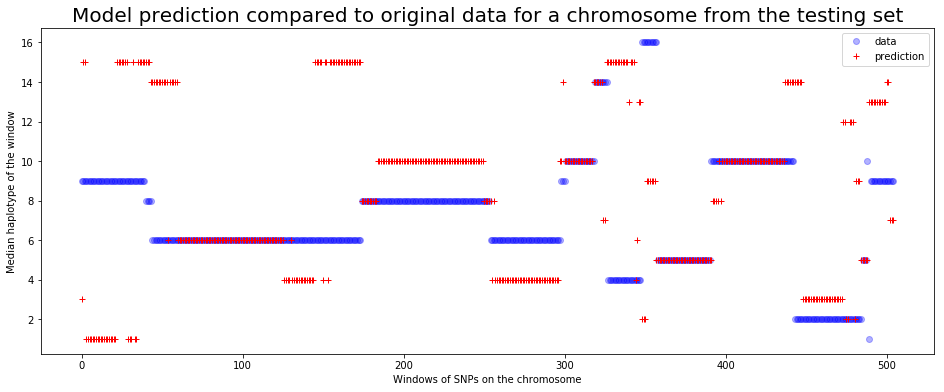

In [187]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot([np.argmax(data)+1 for data in Ydata[0]], 'bo', label="data",alpha=0.3)
ax.plot([np.argmax(pred)+1 for pred in Ypred[0]], 'r+', label="prediction")
ax.legend()
plt.xlabel("Windows of SNPs on the chromosome")
plt.ylabel("Median haplotype of the window")
plt.title("Model prediction compared to original data for a chromosome from the testing set",fontsize=20)
plt.show()

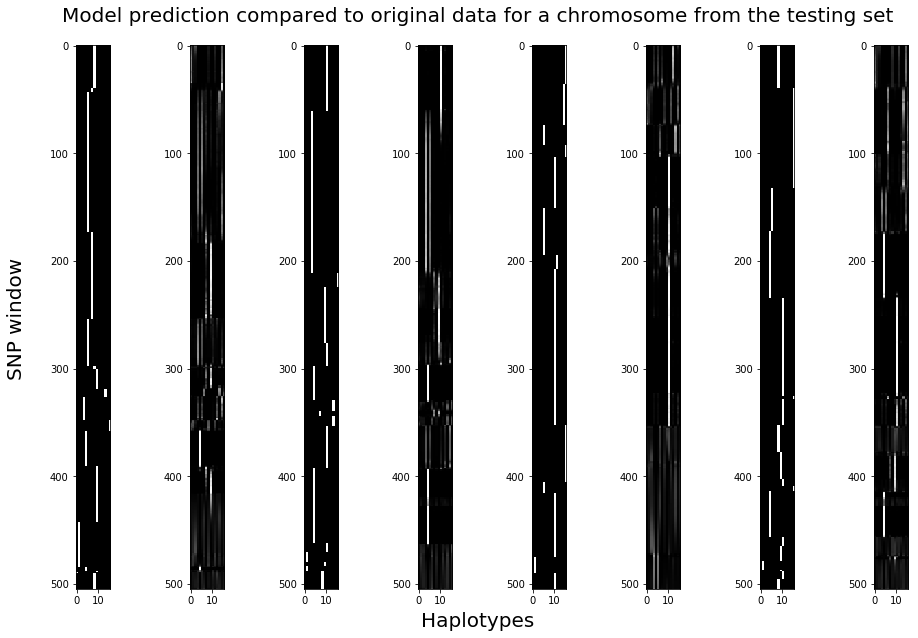

In [188]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8,figsize=(16,10))
ax1.imshow(Ydata[0],cmap="Greys_r", aspect = 0.5)
ax2.imshow(Ypred[0],cmap="Greys_r", aspect = 0.5)
ax3.imshow(Ydata[1],cmap="Greys_r", aspect = 0.5)
ax4.imshow(Ypred[1],cmap="Greys_r", aspect = 0.5)
ax5.imshow(Ydata[2],cmap="Greys_r", aspect = 0.5)
ax6.imshow(Ypred[2],cmap="Greys_r", aspect = 0.5)
ax7.imshow(Ydata[3],cmap="Greys_r", aspect = 0.5)
ax8.imshow(Ypred[3],cmap="Greys_r", aspect = 0.5)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model prediction compared to original data for a chromosome from the testing set', ha='center', va='center',fontsize=20)
plt.show()

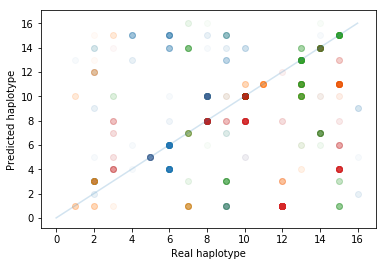

In [189]:
plt.plot([0,16],[0,16],alpha=0.2)
plt.scatter([np.argmax(data)+1 for data in Ydata[0]],[np.argmax(pred)+1 for pred in Ypred[0]],alpha = 0.03)
plt.scatter([np.argmax(data)+1 for data in Ydata[500]],[np.argmax(pred)+1 for pred in Ypred[500]],alpha = 0.03)
plt.scatter([np.argmax(data)+1 for data in Ydata[1015]],[np.argmax(pred)+1 for pred in Ypred[1015]],alpha = 0.03)
plt.scatter([np.argmax(data)+1 for data in Ydata[1500]],[np.argmax(pred)+1 for pred in Ypred[1500]],alpha = 0.03)
plt.xlabel("Real haplotype")
plt.ylabel("Predicted haplotype")
plt.show()

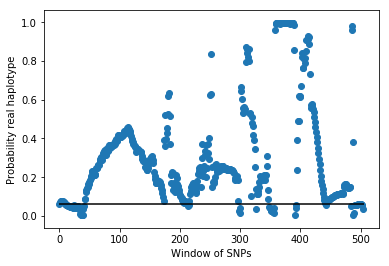

In [190]:
Yproba = []
categories = [np.argmax(data) for data in Ydata[0]]
for k in range(len(Ydata[0])):
    cat = categories[k]
    proba=Ypred[0][k]/sum(Ypred[0][k])
    Yproba.append(proba[cat])
plt.scatter(list(range(len(Ydata[0]))),Yproba)
plt.hlines(1/16,0,len(Ydata[0]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()

# CNN + Bidirectional LSTM + Attention

## Define and train the model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

/Users/jeje/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from attention_decoder import AttentionDecoder

In [4]:
n = 16    # founders
p = 1015  # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 100   # nb of itérations

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants.

In [5]:
with open("Recombinations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo = np.array(haplo[:n])
    d_haplo = np.array(haplo[n:])
display(F_haplo.shape,d_haplo.shape)
        
with open("Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])
    d_geno = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno.shape,d_geno.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [6]:
xtrain = d_geno[:3*I*N//4]
ytrain = d_haplo[:3*I*N//4]
xtest = d_geno[3*I*N//4:]
ytest = d_haplo[3*I*N//4:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((7500, 1015), (7500, 1015), (2500, 1015), (2500, 1015))

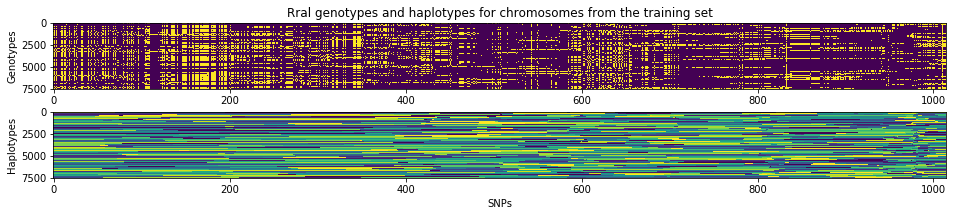

In [7]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
ax1.imshow(xtrain, aspect = 0.01)
ax1.set(ylabel = "Genotypes", title = "Rral genotypes and haplotypes for chromosomes from the training set")
ax2.imshow(ytrain, aspect = 0.01)
ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
plt.show()

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [8]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 2 SNPs-long segments.

In [9]:
def chromosome_segments_output (array):
    A = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        A[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return A

In [22]:
Xtrain = chromosome_alternate_inputs_5(xtrain, F_geno, linkage, n)
display(Xtrain.shape)
Ytrain = chromosome_segments_output(ytrain)[:,:-2]       # Delete 1 SNP to get the right dimension (CNN output)
display(Ytrain.shape)
Xtest = chromosome_alternate_inputs_5(xtest, F_geno, linkage, n)
display(Xtest.shape)
Ytest = chromosome_segments_output(ytest)[:,:-2]
display(Ytest.shape)

(7500, 1015, 49)

(7500, 505, 16)

(2500, 1015, 49)

(2500, 505, 16)

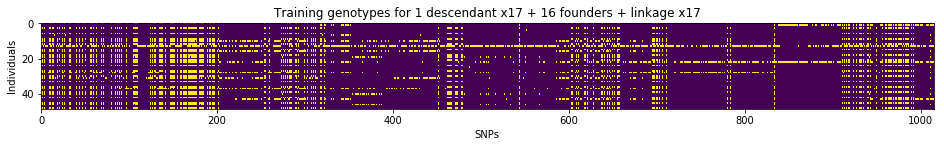

In [23]:
im, ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(Xtrain[0].T, aspect = 2)
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Training genotypes for 1 descendant x17 + 16 founders + linkage x17")
plt.show()

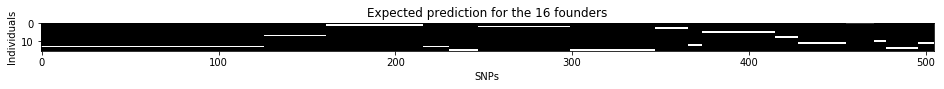

In [24]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.imshow(Ytrain[0].T, aspect = 1, cmap = "Greys_r")
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Expected prediction for the 16 founders")
plt.show()

**Define LSTM** :

In [26]:
K.clear_session()

model_1 = Sequential()
model_1.add(Conv1D(49, kernel_size=3,
                 activation='relu',
                 input_shape=Xtest.shape[1:]))
model_1.add(Conv1D(30, kernel_size=3, activation='relu'))
model_1.add(AveragePooling1D(pool_size=2,strides=2))
model_1.add(Dropout(0.25))
model_1.add(Conv1D(16, kernel_size=3, activation='relu'))
model_1.add(Dropout(0.25))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_1.add(AttentionDecoder(Ytest.shape[1],Ytest.shape[2]))
model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
filepath="Attention1_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1014, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1013, 30)          2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 506, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 506, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 505, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 505, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 505, 16)           272       
__________

In [27]:
plot_model(model_1, show_shapes=True, to_file='Models/Attention1_model.png')

**Train LSTM** :

In [ ]:
epochs=1
model_1.fit(Xtrain, Ytrain,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(Xtest, Ytest))

Train on 7500 samples, validate on 2500 samples
Epoch 1/1


$\to$ Reached **% accuracy after  epochs**.

## Load Check-Pointed model and make predictions : new simulations

In [160]:
with open("Recombinations_haplotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo_test = np.array(haplo[:n])
    d_haplo_test = np.array(haplo[n:])
display(F_haplo_test.shape,d_haplo_test.shape)
        
with open("Recombinations_genotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno_test = np.array(geno[:n])
    d_geno_test = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno_test.shape,d_geno_test.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [161]:
K.clear_session()

model_1 = Sequential()
model_1.add(Conv1D(49, kernel_size=3,
                 activation='relu',
                 input_shape=Xtest.shape[1:]))
model_1.add(Conv1D(30, kernel_size=3, activation='relu'))
model_1.add(AveragePooling1D(pool_size=2,strides=2))
model_1.add(Dropout(0.25))
model_1.add(Conv1D(16, kernel_size=3, activation='relu'))
model_1.add(Dropout(0.25))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(TimeDistributed(Dense(16, activation='relu')))
model_1.add(Dropout(0.5))
model_1.add(Bidirectional(LSTM(8, return_sequences=True)))
model_1.add(TimeDistributed(Dense(Ytest.shape[2], activation='softmax')))
model_1.load_weights("Models/Attention1_model_weights/Attention1_model_weights-improvement-99-0.43.hdf5")       # load weights
model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1014, 49)          4851      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1013, 30)          2970      
_________________________________________________________________
average_pooling1d_1 (Average (None, 506, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 506, 30)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 505, 16)           976       
_________________________________________________________________
dropout_2 (Dropout)          (None, 505, 16)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 505, 16)           272       
__________

In [185]:
Xdata = chromosome_alternate_inputs_1(d_geno_test, F_geno_test, linkage, n)
display(Xdata.shape)
Ydata = chromosome_segments_output(d_haplo_test)[:,:-2]       # Delete 1 SNP to get the right dimension (CNN output)
display(Ydata.shape)
Ypred = model_1.predict(Xdata)
display(Ypred.shape)

(10000, 1015, 49)

(10000, 505, 16)

(10000, 505, 16)

In [186]:
model_1.evaluate(Xdata, Ydata)

10000/10000 [==============================] - 178s 18ms/step


[1.7003124328613282, 0.4092665348529816]

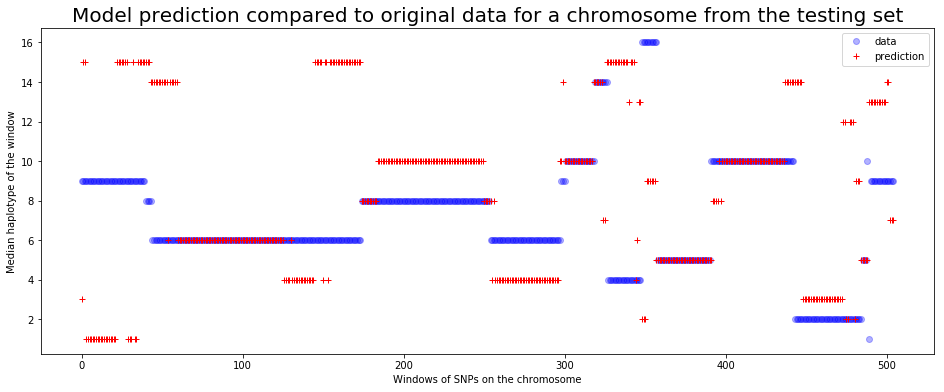

In [187]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot([np.argmax(data)+1 for data in Ydata[0]], 'bo', label="data",alpha=0.3)
ax.plot([np.argmax(pred)+1 for pred in Ypred[0]], 'r+', label="prediction")
ax.legend()
plt.xlabel("Windows of SNPs on the chromosome")
plt.ylabel("Median haplotype of the window")
plt.title("Model prediction compared to original data for a chromosome from the testing set",fontsize=20)
plt.show()

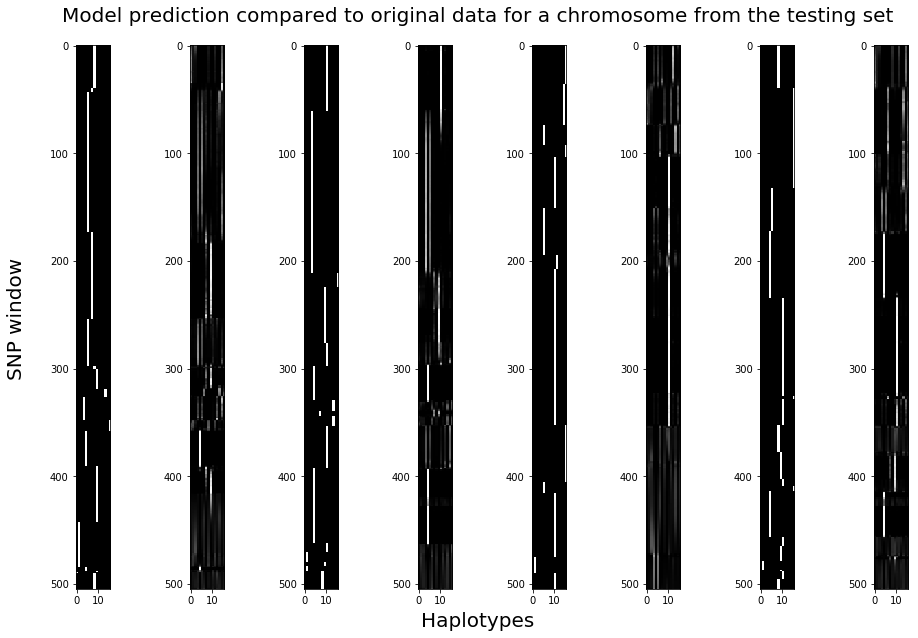

In [188]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1,8,figsize=(16,10))
ax1.imshow(Ydata[0],cmap="Greys_r", aspect = 0.5)
ax2.imshow(Ypred[0],cmap="Greys_r", aspect = 0.5)
ax3.imshow(Ydata[1],cmap="Greys_r", aspect = 0.5)
ax4.imshow(Ypred[1],cmap="Greys_r", aspect = 0.5)
ax5.imshow(Ydata[2],cmap="Greys_r", aspect = 0.5)
ax6.imshow(Ypred[2],cmap="Greys_r", aspect = 0.5)
ax7.imshow(Ydata[3],cmap="Greys_r", aspect = 0.5)
ax8.imshow(Ypred[3],cmap="Greys_r", aspect = 0.5)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model prediction compared to original data for a chromosome from the testing set', ha='center', va='center',fontsize=20)
plt.show()

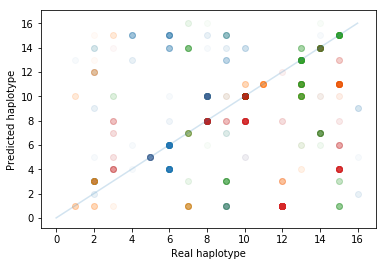

In [189]:
plt.plot([0,16],[0,16],alpha=0.2)
plt.scatter([np.argmax(data)+1 for data in Ydata[0]],[np.argmax(pred)+1 for pred in Ypred[0]],alpha = 0.03)
plt.scatter([np.argmax(data)+1 for data in Ydata[500]],[np.argmax(pred)+1 for pred in Ypred[500]],alpha = 0.03)
plt.scatter([np.argmax(data)+1 for data in Ydata[1015]],[np.argmax(pred)+1 for pred in Ypred[1015]],alpha = 0.03)
plt.scatter([np.argmax(data)+1 for data in Ydata[1500]],[np.argmax(pred)+1 for pred in Ypred[1500]],alpha = 0.03)
plt.xlabel("Real haplotype")
plt.ylabel("Predicted haplotype")
plt.show()

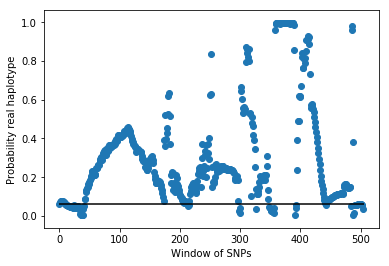

In [190]:
Yproba = []
categories = [np.argmax(data) for data in Ydata[0]]
for k in range(len(Ydata[0])):
    cat = categories[k]
    proba=Ypred[0][k]/sum(Ypred[0][k])
    Yproba.append(proba[cat])
plt.scatter(list(range(len(Ydata[0]))),Yproba)
plt.hlines(1/16,0,len(Ydata[0]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()

# CNN + Bidirectional LSTM + Attention + less parameters

## Define and train the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

Using TensorFlow backend.


In [2]:
from attention_decoder import AttentionDecoder

In [3]:
n = 16    # founders
p = 1015  # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 100   # nb of itérations

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants.

In [4]:
with open("Recombinations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo = np.array(haplo[:n])
    d_haplo = np.array(haplo[n:])
display(F_haplo.shape,d_haplo.shape)
        
with open("Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])
    d_geno = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno.shape,d_geno.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [5]:
xtrain = d_geno[:3*I*N//4]
ytrain = d_haplo[:3*I*N//4]
xtest = d_geno[3*I*N//4:]
ytest = d_haplo[3*I*N//4:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((7500, 1015), (7500, 1015), (2500, 1015), (2500, 1015))

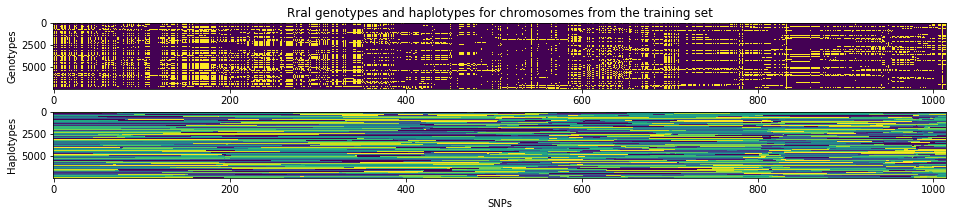

In [6]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
ax1.imshow(xtrain, aspect = 0.01)
ax1.set(ylabel = "Genotypes", title = "Rral genotypes and haplotypes for chromosomes from the training set")
ax2.imshow(ytrain, aspect = 0.01)
ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
plt.show()

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [7]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 4 SNPs-long segments.

In [8]:
def chromosome_segments_output_2 (array):
    A = np.zeros((len(array),len(array[0])//4,16))
    for k in range(len(array)) :
        individual = array[k]
        A[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//4*4],(-1,4))])
    return A

In [9]:
Xtrain = chromosome_alternate_inputs_5(xtrain, F_geno, linkage, n)
display(Xtrain.shape)
Ytrain = chromosome_segments_output_2(ytrain)[:,:-4]       # Delete 4 SNPs to get the right dimension (CNN output)
display(Ytrain.shape)
Xtest = chromosome_alternate_inputs_5(xtest, F_geno, linkage, n)
display(Xtest.shape)
Ytest = chromosome_segments_output_2(ytest)[:,:-4]
display(Ytest.shape)

(7500, 1015, 49)

(7500, 249, 16)

(2500, 1015, 49)

(2500, 249, 16)

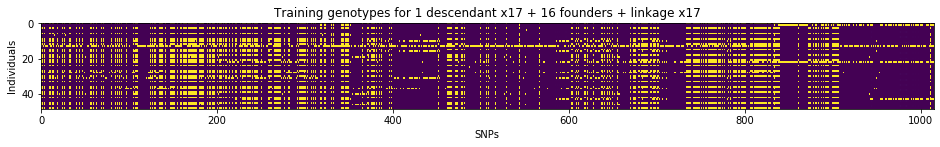

In [10]:
im, ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(Xtrain[0].T, aspect = 2)
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Training genotypes for 1 descendant x17 + 16 founders + linkage x17")
plt.show()

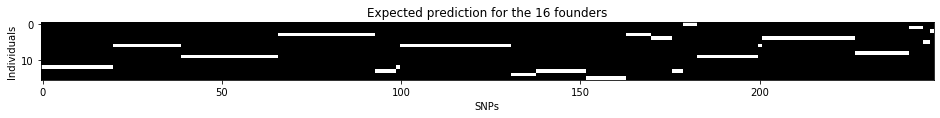

In [11]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.imshow(Ytrain[0].T, aspect = 1, cmap = "Greys_r")
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Expected prediction for the 16 founders")
plt.show()

**Define LSTM** :

In [12]:
K.clear_session()

model_2 = Sequential()
model_2.add(Conv1D(49, kernel_size=3,
                 activation='relu',
                 input_shape=Xtest.shape[1:]))
model_2.add(Conv1D(35, kernel_size=3, activation='relu'))
model_2.add(AveragePooling1D(pool_size=2,strides=2))
model_2.add(Dropout(0.25))
model_2.add(Conv1D(25, kernel_size=3, activation='relu'))
model_2.add(AveragePooling1D(pool_size=2,strides=2))
model_2.add(Dropout(0.25))
model_2.add(Conv1D(16, kernel_size=3, activation='relu'))
model_2.add(Dropout(0.25))
model_2.add(TimeDistributed(Dense(16, activation='relu')))
model_2.add(Dropout(0.5))
model_2.add(TimeDistributed(Dense(16, activation='relu')))
model_2.add(Dropout(0.5))
model_2.add(Bidirectional(LSTM(8, return_sequences=True)))
model_2.add(AttentionDecoder(100,16))
model_2.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
filepath="Attention2_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model_2.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1013, 49)          7252      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1011, 35)          5180      
_________________________________________________________________
average_pooling1d_1 (Average (None, 505, 35)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 505, 35)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 503, 25)           2650      
_________________________________________________________________
average_pooling1d_2 (

In [22]:
plot_model(model_2, show_shapes=True, to_file='Models/Attention2_model.png')

**Train LSTM** :

In [ ]:
epochs=1
model_2.fit(Xtrain, Ytrain,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(Xtest, Ytest))

Train on 7500 samples, validate on 2500 samples
Epoch 1/1
1472/7500 [====>.........................] - ETA: 44:32 - loss: 2.7625 - acc: 0.0865

$\to$ Reached **37% accuracy after 38 epochs**.

# CNN + Bidirectional LSTM + Attention // translation

## Define and train the model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM, TimeDistributed, Bidirectional
from keras.layers import Conv1D, Conv2D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils, plot_model
import pickle

/Users/jeje/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from attention_decoder import AttentionDecoder

In [4]:
n = 16    # founders
p = 1015  # nb of SNPs
G = 20    # nb of generations
N = 100   # number recombining individuals in a generation after sampling
I = 100   # nb of itérations

**Import simulations** : genotypes and haplotypes, F = founders, d = descendants.

In [5]:
with open("Recombinations_haplotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo = np.array(haplo[:n])
    d_haplo = np.array(haplo[n:])
display(F_haplo.shape,d_haplo.shape)
        
with open("Recombinations_genotypes_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno = np.array(geno[:n])
    d_geno = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno.shape,d_geno.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [6]:
xtrain = d_geno[:3*I*N//4]
ytrain = d_haplo[:3*I*N//4]
xtest = d_geno[3*I*N//4:]
ytest = d_haplo[3*I*N//4:]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((7500, 1015), (7500, 1015), (2500, 1015), (2500, 1015))

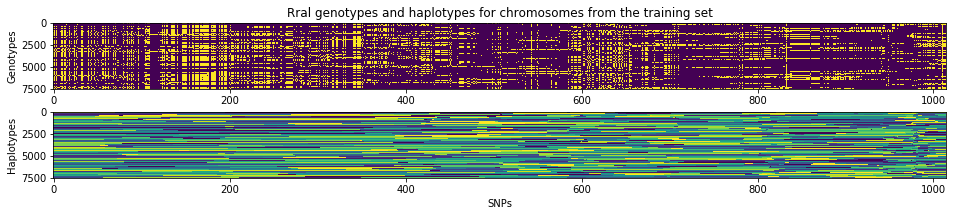

In [7]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,3))
ax1.imshow(xtrain, aspect = 0.01)
ax1.set(ylabel = "Genotypes", title = "Rral genotypes and haplotypes for chromosomes from the training set")
ax2.imshow(ytrain, aspect = 0.01)
ax2.set(ylabel = "Haplotypes", xlabel = "SNPs")
plt.show()

**Input genotypes** : creating an "image" with the descendant x17 alterning with the 16 founders and the linkage.

In [103]:
def chromosome_alternate_inputs_5 (array, F_geno, linkage, n):
    A = np.zeros((array.shape[0],array.shape[1],3*n+1))
    for k in range(len(array)) :
        individual = array[k]
        a = individual[:, np.newaxis]
        for l in range(len(F_geno)) :
            a=np.concatenate([a,F_geno[l:l+1].T, linkage[:, np.newaxis], individual[:, np.newaxis]], axis = 1)
        A[k]=a
    return A

**Output haplotypes** in 2 SNPs-long segments.

In [76]:
def chromosome_segments_output (array):
    A = np.zeros((len(array),len(array[0])//2,16))
    for k in range(len(array)) :
        individual = array[k]
        A[k] = np.array([np_utils.to_categorical(segment[1]-1,16) for segment in np.reshape(individual[:len(individual)//2*2],(-1,2))])
    return A

In [119]:
Xtrain = chromosome_alternate_inputs_5(xtrain[:,:100], F_geno[:,:100], linkage[:100], n)
display(Xtrain.shape)
Ytrain = chromosome_segments_output(ytrain[:,:100])[:,:-4]       # Delete 4 SNPs to get the right dimension (CNN output)
display(Ytrain.shape)
Xtest = chromosome_alternate_inputs_5(xtest[:,:100], F_geno[:,:100], linkage[:100], n)
display(Xtest.shape)
Ytest = chromosome_segments_output(ytest[:,:100])[:,:-4]
display(Ytest.shape)

(7500, 100, 49)

(7500, 46, 16)

(2500, 100, 49)

(2500, 46, 16)

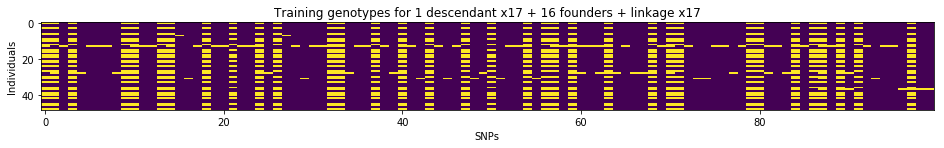

In [113]:
im, ax = plt.subplots(1,1,figsize=(16,10))
ax.imshow(Xtrain[1].T, aspect = 0.2)
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Training genotypes for 1 descendant x17 + 16 founders + linkage x17")
plt.show()

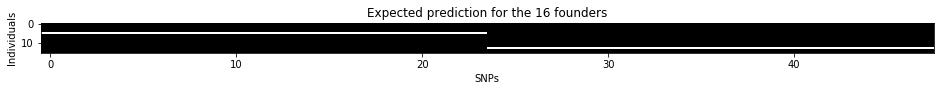

In [115]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.imshow(Ytrain[2].T, aspect = 0.1, cmap="Greys_r")
ax.set(xlabel = "SNPs", ylabel = "Individuals", title = "Expected prediction for the 16 founders")
plt.show()

**Define LSTM** :

In [123]:
K.clear_session()

model_3 = Sequential()
model_3.add(Conv1D(49, kernel_size=3,
                 activation='relu',
                 input_shape=Xtest.shape[1:]))
model_3.add(Conv1D(40, kernel_size=3, activation='relu'))
model_3.add(AveragePooling1D(pool_size=2,strides=2))
model_3.add(Dropout(0.25))
model_3.add(Conv1D(30, kernel_size=3, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Bidirectional(LSTM(8, return_sequences=True)))
model_3.add(AttentionDecoder(46,16))
model_3.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
filepath="Attention3_model_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 98, 49)            7252      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 40)            5920      
_________________________________________________________________
average_pooling1d_1 (Average (None, 48, 40)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 40)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 30)            3630      
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 30)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 46, 16)            496       
__________

In [124]:
plot_model(model_3, show_shapes=True, to_file='Models/Attention3_model.png')

**Train LSTM** :

In [125]:
epochs=50
model_3.fit(Xtrain, Ytrain,
          epochs=epochs,
          callbacks=callbacks_list,
          verbose=1,
          validation_data=(Xtest, Ytest))

Train on 7500 samples, validate on 2500 samples
Epoch 1/50
7500/7500 [==============================] - 175s 23ms/step - loss: 2.2499 - acc: 0.2059 - val_loss: 1.9205 - val_acc: 0.2540

Epoch 00001: val_acc improved from -inf to 0.25398, saving model to Attention3_model_weights-improvement-01-0.25.hdf5
Epoch 2/50
7500/7500 [==============================] - 166s 22ms/step - loss: 1.5462 - acc: 0.4128 - val_loss: 1.7463 - val_acc: 0.2858

Epoch 00002: val_acc improved from 0.25398 to 0.28583, saving model to Attention3_model_weights-improvement-02-0.29.hdf5
Epoch 3/50
7500/7500 [==============================] - 183s 24ms/step - loss: 1.2757 - acc: 0.4910 - val_loss: 1.5530 - val_acc: 0.3147

Epoch 00003: val_acc improved from 0.28583 to 0.31466, saving model to Attention3_model_weights-improvement-03-0.31.hdf5
Epoch 4/50
7500/7500 [==============================] - 156s 21ms/step - loss: 1.1519 - acc: 0.5192 - val_loss: 1.5240 - val_acc: 0.3522

Epoch 00004: val_acc improved from 0.314

$\to$ Reached **45% accuracy after 37 epochs**.

## Load Check-Pointed model and make predictions : new simulations

In [126]:
with open("Recombinations_haplotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    haplo = pickle.load(handler)
    F_haplo_test = np.array(haplo[:n])
    d_haplo_test = np.array(haplo[n:])
display(F_haplo_test.shape,d_haplo_test.shape)
        
with open("Recombinations_genotypes_test_n{0}_p{1}_G{2}_N{3}_I{4}.pkl".format(n,p,G,N,I),"rb") as handler:
    geno = pickle.load(handler)
    F_geno_test = np.array(geno[:n])
    d_geno_test = np.array(geno[n:])
    
with open("Linkage_p{}.pkl".format(p),"rb") as handler:
    linkage = pickle.load(handler)

display(F_geno_test.shape,d_geno_test.shape, linkage.shape)

(16, 1015)

(10000, 1015)

(16, 1015)

(10000, 1015)

(1015,)

In [129]:
K.clear_session()

model_3 = Sequential()
model_3.add(Conv1D(49, kernel_size=3,
                 activation='relu',
                 input_shape=Xtest.shape[1:]))
model_3.add(Conv1D(40, kernel_size=3, activation='relu'))
model_3.add(AveragePooling1D(pool_size=2,strides=2))
model_3.add(Dropout(0.25))
model_3.add(Conv1D(30, kernel_size=3, activation='relu'))
model_3.add(Dropout(0.25))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Bidirectional(LSTM(8, return_sequences=True)))
model_3.add(AttentionDecoder(46,16))
model_3.load_weights("Models/Attention3_model_weights/Attention3_model_weights-improvement-37-0.45.hdf5")       # load weights
model_3.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 98, 49)            7252      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 40)            5920      
_________________________________________________________________
average_pooling1d_1 (Average (None, 48, 40)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 40)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 30)            3630      
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 30)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 46, 16)            496       
__________

In [132]:
Xdata = chromosome_alternate_inputs_5(d_geno_test[:,:100], F_geno_test[:,:100], linkage[:100], n)
display(Xdata.shape)
Ydata = chromosome_segments_output(d_haplo_test[:,:100])[:,:-4]       # Delete 4 SNPs to get the right dimension (CNN output)
display(Ydata.shape)
Ypred = model_3.predict(Xdata)
display(Ypred.shape)

(10000, 100, 49)

(10000, 46, 16)

(10000, 46, 16)

In [133]:
model_3.evaluate(Xdata, Ydata)

10000/10000 [==============================] - 81s 8ms/step


[1.285810456085205, 0.44394565150737764]

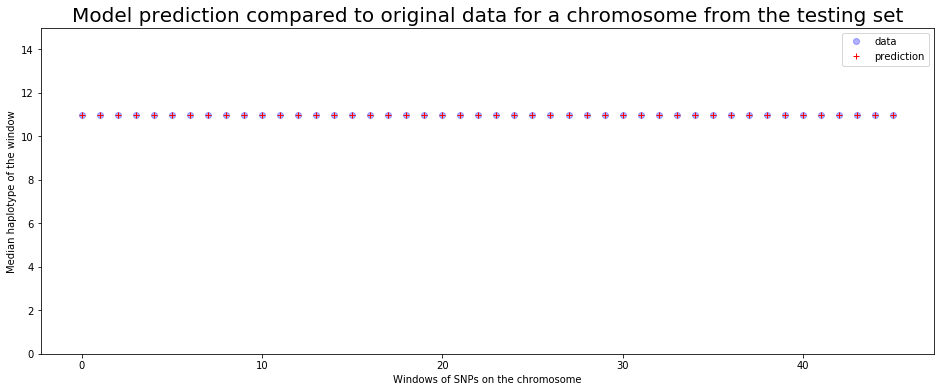

In [148]:
im, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot([np.argmax(data)+1 for data in Ydata[1]], 'bo', label="data",alpha=0.3)
ax.plot([np.argmax(pred)+1 for pred in Ypred[1]], 'r+', label="prediction")
ax.set(ylim=[0,15])
ax.legend()
plt.xlabel("Windows of SNPs on the chromosome")
plt.ylabel("Median haplotype of the window")
plt.title("Model prediction compared to original data for a chromosome from the testing set",fontsize=20)
plt.show()

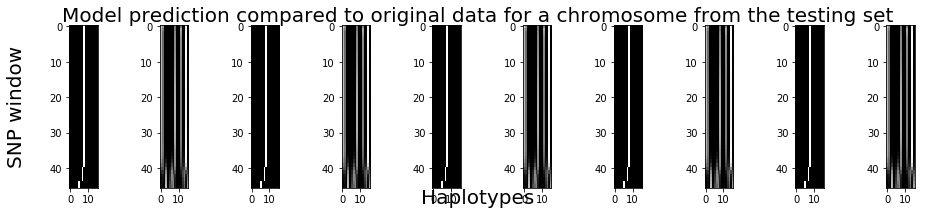

In [143]:
fig, ax = plt.subplots(1,10,figsize=(16,3))
for i in range(0,len(ax),2) :
    ax[i].imshow(Ydata[0],cmap="Greys_r", aspect = 2)
    ax[i+1].imshow(Ypred[0],cmap="Greys_r", aspect = 2)
fig.text(0.5, 0.08, 'Haplotypes', ha='center', va='center',fontsize=20)
fig.text(0.1, 0.5, 'SNP window', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5, 0.92, 'Model prediction compared to original data for a chromosome from the testing set', ha='center', va='center',fontsize=20)
plt.show()

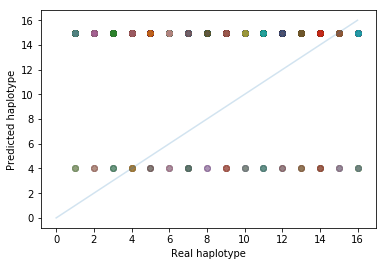

In [152]:
plt.plot([0,16],[0,16],alpha=0.2)
for i in range(0, Ydata.shape[0], 50):
    plt.scatter([np.argmax(data)+1 for data in Ydata[i]],[np.argmax(pred)+1 for pred in Ypred[0]],alpha = 0.03)
plt.xlabel("Real haplotype")
plt.ylabel("Predicted haplotype")
plt.show()

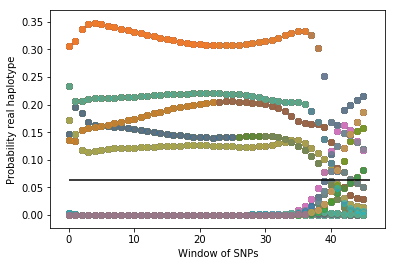

In [151]:
for i in range(0, Ydata.shape[0], 10):
    Yproba = []
    categories = [np.argmax(data) for data in Ydata[i]]
    for k in range(len(Ydata[i])):
        cat = categories[k]
        proba=Ypred[0][k]/sum(Ypred[0][k])
        Yproba.append(proba[cat])
    plt.scatter(list(range(len(Ydata[i]))),Yproba, alpha = 0.5)
plt.hlines(1/16,0,len(Ydata[i]))
plt.xlabel("Window of SNPs")
plt.ylabel("Probability real haplotype")
plt.show()